In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

import time
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics

# NLP
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB # NLP classification
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

# Quick Summary libraries to find the optimal model
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier

# Neural Network
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping

# Note
1. Baseline: Linear Regression -> Is it okay? Metric -> R squared, RMSE, Std.
2. Compare to multiple models -> Try Neural Net -> Hyper Tune Linear Model
2.2. Explanable Boosting
3. Explain why its' work or doesn't work

In [2]:
data = pd.read_csv("dataset/data_2020.csv")

In [3]:
data.shape

(2232, 12)

In [4]:
data.head()

,Job_title,Company,State,City,Min_Salary,Max_Salary,Job_Desc,Industry,Rating,Date_Posted,Valid_until,Job_Type
0,Senior Salesforce Developer,National Debt Relief,NY,New York,44587,82162,Principle Duties & Responsibilities:\n\nAnalyz...,Finance,4.00,2020-05-08,2020-06-07,FULL_TIME
1,"DEPUTY EXECUTIVE DIRECTOR, PROGRAM AND LEGAL A...",National Advocates for Pregnant Women,NY,New York,125410,212901,"For FULL Job Announcement, visit our website: ...",NaN,NaN,2020-04-28,2020-06-07,FULL_TIME
2,Emergency Veterinarian - NYC,Veterinary Emergency Group,NY,New York,94715,103279,Emergency VeterinarianThe family you will be j...,Health Care,4.90,2020-05-05,2020-06-07,FULL_TIME
3,ABA Therapist,Kids Learning Loft Applied Behavior Analysis S...,NY,Williston Park,20000,35000,Here at Kids Learning Loft Applied Behavior An...,NaN,NaN,2020-05-07,2020-06-07,PART_TIME
4,Construction Project Manager,The LiRo Group,NY,Brooklyn,54991,143860,Overview\n\nRanked among the nation's top 10 C...,"Construction, Repair & Maintenance",3.80,2020-05-08,2020-06-07,FULL_TIME


In [5]:
data.isnull().sum()

Job_title        0
Company          0
State            0
City             0
Min_Salary       0
Max_Salary       0
Job_Desc         0
Industry       202
Rating         123
Date_Posted      0
Valid_until      0
Job_Type         0
dtype: int64

In [6]:
data["Industry"] = data["Industry"].fillna("Unknown")

In [7]:
data["Rating"] = data["Rating"].fillna(data["Rating"].mean())

In [8]:
# Count unique
print(data["Job_title"].nunique())
print(data["City"].nunique())
print(data["State"].nunique())
print(data["Industry"].nunique())

1255
115
10
24


In [9]:
# # We would recategorised the job title to find key words
data["Job_title"] = data["Job_title"].str.lower()

In [10]:
data["Job_title"].str.contains("senior")

0        True
1       False
2       False
3       False
4       False
        ...  
2227    False
2228    False
2229    False
2230     True
2231     True
Name: Job_title, Length: 2232, dtype: bool

In [11]:
# Regroup Job Title to categories
# "senior + data + scientist"
data["is_senior"] = data["Job_title"].str.contains("senior")

#"data + scientist"
data["is_scientist"] = data["Job_title"].str.contains("scientist")

# "data + analyst"
data["is_analyst"] = data["Job_title"].str.contains("analyst")

# engineer
data["is_engineer"] = data["Job_title"].str.contains("engineer")

# "manager"
data["is_manager"] = data["Job_title"].str.contains("manager")

# "data" 
data["is_data"] = data["Job_title"].str.contains("data")

# "lead" 
data["is_lead"] = data["Job_title"].str.contains("lead")

# "principal" 
data["is_principal"] = data["Job_title"].str.contains("principal")

In [13]:
data.head()

,Job_title,Company,State,City,Min_Salary,Max_Salary,Job_Desc,Industry,Rating,Date_Posted,Valid_until,Job_Type,is_senior,is_scientist,is_analyst,is_engineer,is_manager,is_data,is_lead,is_principal
0,senior salesforce developer,National Debt Relief,NY,New York,44587,82162,Principle Duties & Responsibilities:\n\nAnalyz...,Finance,4.00,2020-05-08,2020-06-07,FULL_TIME,True,False,False,False,False,False,False,False
1,"deputy executive director, program and legal a...",National Advocates for Pregnant Women,NY,New York,125410,212901,"For FULL Job Announcement, visit our website: ...",Unknown,3.79,2020-04-28,2020-06-07,FULL_TIME,False,False,False,False,False,False,False,False
2,emergency veterinarian - nyc,Veterinary Emergency Group,NY,New York,94715,103279,Emergency VeterinarianThe family you will be j...,Health Care,4.90,2020-05-05,2020-06-07,FULL_TIME,False,False,False,False,False,False,False,False
3,aba therapist,Kids Learning Loft Applied Behavior Analysis S...,NY,Williston Park,20000,35000,Here at Kids Learning Loft Applied Behavior An...,Unknown,3.79,2020-05-07,2020-06-07,PART_TIME,False,False,False,False,False,False,False,False
4,construction project manager,The LiRo Group,NY,Brooklyn,54991,143860,Overview\n\nRanked among the nation's top 10 C...,"Construction, Repair & Maintenance",3.80,2020-05-08,2020-06-07,FULL_TIME,False,False,False,False,True,False,False,False


In [14]:
data["Min_Salary"].describe()

count     2232.00
mean     82442.35
std      33414.91
min      19857.00
25%      55720.25
50%      81511.00
75%     103480.50
max     205735.00
Name: Min_Salary, dtype: float64

In [15]:
ProfileReport(
    data,
    title="Profile Report for variables"   
)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

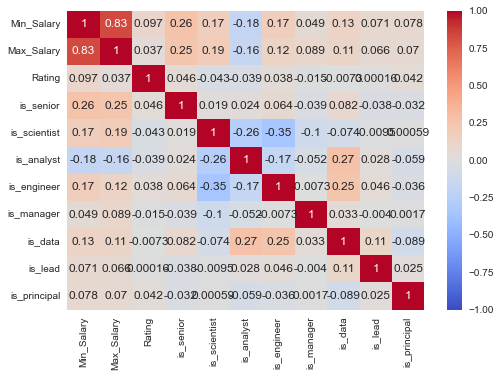

In [16]:
sns.heatmap(data.corr(), 
            cmap="coolwarm", # "coolwarm" and "viridis" are better for color-blindness
            annot = True,
            # Set these two so our color scale reflect the range of correlation values better
            vmax = 1, 
            vmin = -1)
plt.yticks(rotation=0);

In [17]:
# train_dum = pd.concat([X_train_dummies,y_train], axis=1)

In [18]:
# Check correlation with Min_Salary to find interesting variables.
# plt.figure(figsize=(10,12))
# sns.heatmap(train_dum.corr()[['Min_Salary']].sort_values(by='Min_Salary', ascending=False),
#             annot=True)
# plt.title("Top 15 variables with highest correlation with saleprice");

### Baseline Model

In [19]:
data.head()

,Job_title,Company,State,City,Min_Salary,Max_Salary,Job_Desc,Industry,Rating,Date_Posted,Valid_until,Job_Type,is_senior,is_scientist,is_analyst,is_engineer,is_manager,is_data,is_lead,is_principal
0,senior salesforce developer,National Debt Relief,NY,New York,44587,82162,Principle Duties & Responsibilities:\n\nAnalyz...,Finance,4.00,2020-05-08,2020-06-07,FULL_TIME,True,False,False,False,False,False,False,False
1,"deputy executive director, program and legal a...",National Advocates for Pregnant Women,NY,New York,125410,212901,"For FULL Job Announcement, visit our website: ...",Unknown,3.79,2020-04-28,2020-06-07,FULL_TIME,False,False,False,False,False,False,False,False
2,emergency veterinarian - nyc,Veterinary Emergency Group,NY,New York,94715,103279,Emergency VeterinarianThe family you will be j...,Health Care,4.90,2020-05-05,2020-06-07,FULL_TIME,False,False,False,False,False,False,False,False
3,aba therapist,Kids Learning Loft Applied Behavior Analysis S...,NY,Williston Park,20000,35000,Here at Kids Learning Loft Applied Behavior An...,Unknown,3.79,2020-05-07,2020-06-07,PART_TIME,False,False,False,False,False,False,False,False
4,construction project manager,The LiRo Group,NY,Brooklyn,54991,143860,Overview\n\nRanked among the nation's top 10 C...,"Construction, Repair & Maintenance",3.80,2020-05-08,2020-06-07,FULL_TIME,False,False,False,False,True,False,False,False


In [20]:
# X & y
features = ["Rating",
            'is_senior',
            'is_data',
            'is_scientist',
            'is_analyst',
            'is_engineer',
            'is_manager']
# categorical features = ["Company","State","Industry","Job_Type"]

X = data[features]
ymin = data["Min_Salary"]
ymax = data["Max_Salary"]
yavg = (data["Min_Salary"]+data["Max_Salary"])/2

In [21]:
# Let's start with Min prediction
X_train, X_test, y_train, y_test = train_test_split(X,ymin,random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

X_train.index

# Split for y_max
X_train, X_test, y_max_train, y_max_test = train_test_split(X,ymax,random_state=42)

X_train.index

# Split for y_max
X_train, X_test, y_avg_train, y_avg_test = train_test_split(X,yavg,random_state=42)

X_train.index

X_train.head()

,Rating,is_senior,is_data,is_scientist,is_analyst,is_engineer,is_manager
483,3.50,False,True,False,False,True,False
1323,3.40,False,True,False,True,False,False
923,3.70,False,True,False,False,True,False
1974,3.20,False,True,False,False,False,False
221,4.00,False,False,False,False,False,False


In [22]:
# Let's start with Min prediction
X_train, X_test, y_train, y_test = train_test_split(X,ymin,random_state=42)
    
# Split for y_max
X_train, X_test, y_max_train, y_max_test = train_test_split(X,ymax,random_state=42)
    
# Split for y_avg
X_train, X_test, y_avg_train, y_avg_test = train_test_split(X,yavg,random_state=42)


In [23]:
def cal_metrics(model, X_train, X_test, log_y = False):
    """Print model metrics and return regression model
    from given X_train, X_test, and log result,
    it returns R2 and RMSE of y """
    
    if log_y == False:
        y_preds = model.predict(X_train)
        print('Training R2:', metrics.r2_score(y_train, y_preds))
        print('Training RMSE:', metrics.mean_squared_error(y_train, y_preds, squared=False))
        
        y_preds = model.predict(X_test)
        print('Testing R2:', metrics.r2_score(y_test, y_preds))
        print('Testing RMSE:', metrics.mean_squared_error(y_test, y_preds, squared=False))
    
    else:
        y_train_log = np.log(y_train)
        y_test_log = np.log(y_test)
        y_preds = linear.predict(X_train) # Check X_train with dummies
        print('Training R2:', metrics.r2_score(y_train_log, y_preds))
        print('Training RMSE:', metrics.mean_squared_error(np.exp(y_train_log), np.exp(y_preds), squared=False))
        
        y_preds = linear.predict(X_test)
        print('Training R2:', metrics.r2_score(y_test_log, y_preds))
        print('Training RMSE:', metrics.mean_squared_error(np.exp(y_test_log), np.exp(y_preds), squared=False))

In [24]:
linear = LinearRegression()
linear.fit(X_train, y_train)
cal_metrics(linear, X_train, X_test)

Training R2: 0.1868984752315881
Training RMSE: 29672.955494825095
Testing R2: 0.14818184589035166
Testing RMSE: 32172.30092511318


In [25]:
linear.coef_

array([  5142.60621657,  23008.87411654,   6404.45040056,  13988.29429075,
       -13992.52800142,  15697.18420615,  13475.14302372])

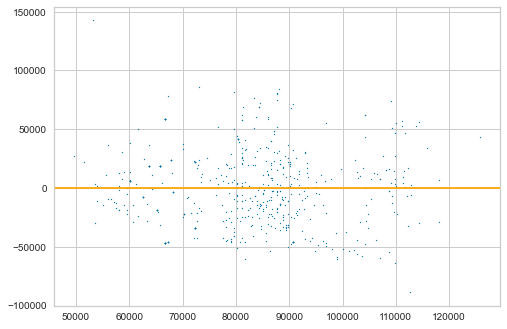

In [27]:
y_preds = linear.predict(X_test)
resids = y_test - y_preds
plt.scatter(y_preds, resids, s=1)
plt.axhline(0, color="orange");

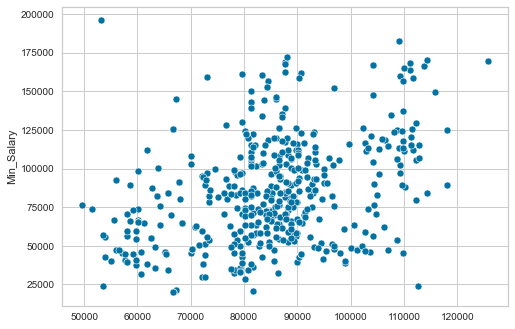

In [28]:
sns.scatterplot(y_preds,y_test);

In [29]:
# lazy = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
# models,predictions = lazy.fit(X_train, X_test, y_train, y_test)

# print(models)

### Model with interaction terms

In [30]:
# Interaction terms for data roles
data["is_data_scientist"] = data["is_data"] * data["is_scientist"]
data["is_data_analyst"] = data["is_data"] * data["is_analyst"]
data["is_data_engineer"] = data["is_data"] * data["is_engineer"]

is_col = data.columns[data.columns.str.contains("is")].to_list()
is_col

features = ["Rating"]
features = ["Rating"] + is_col
X = data[features]
ymin = data["Min_Salary"]
ymax = data["Max_Salary"]
yavg = (data["Min_Salary"]+data["Max_Salary"])/2

In [31]:
data.groupby(["is_data_scientist","is_senior"])["Min_Salary"].describe()

count      mean      std      min      25%  \
is_data_scientist is_senior                                                
False             False     1484.00  75126.88 31327.60 19857.00 50013.00   
                  True       267.00  99021.86 38277.38 37244.00 67071.00   
True              False      398.00  91983.04 26814.30 39825.00 73030.00   
                  True        83.00 114156.17 32740.20 24041.00 92536.50   

                                  50%       75%       max  
is_data_scientist is_senior                                
False             False      72098.50  94715.00 195818.00  
                  True      100185.00 124166.50 205735.00  
True              False      88809.00 110377.00 175846.00  
                  True      112491.00 136866.00 191071.00

In [32]:
features

['Rating',
 'is_senior',
 'is_scientist',
 'is_analyst',
 'is_engineer',
 'is_manager',
 'is_data',
 'is_lead',
 'is_principal',
 'is_data_scientist',
 'is_data_analyst',
 'is_data_engineer']

In [33]:
X

,Rating,is_senior,is_scientist,is_analyst,is_engineer,is_manager,is_data,is_lead,is_principal,is_data_scientist,is_data_analyst,is_data_engineer
0,4.00,True,False,False,False,False,False,False,False,False,False,False
1,3.79,False,False,False,False,False,False,False,False,False,False,False
2,4.90,False,False,False,False,False,False,False,False,False,False,False
3,3.79,False,False,False,False,False,False,False,False,False,False,False
4,3.80,False,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2227,3.70,False,False,False,True,False,True,False,False,False,False,True
2228,3.70,False,False,False,True,False,True,False,False,False,False,True
2229,3.70,False,False,False,True,False,True,False,False,False,False,True
2230,3.70,True,False,False,False,False,True,False,False,False,False,False


In [34]:
# Let's start with Min prediction
X_train, X_test, y_train, y_test = train_test_split(X,ymin,random_state=42)
    
# Split for y_max
X_train, X_test, y_max_train, y_max_test = train_test_split(X,ymax,random_state=42)
    
# Split for y_avg
X_train, X_test, y_avg_train, y_avg_test = train_test_split(X,yavg,random_state=42)


In [35]:
linear = LinearRegression()
linear.fit(X_train, y_train)
cal_metrics(linear, X_train, X_test)

Training R2: 0.22655483180312086
Training RMSE: 28940.31026528003
Testing R2: 0.18441881095549928
Testing RMSE: 31480.54748520293


In [36]:
X_train.shape

(1674, 12)

### Model with categorical variables (Company, State, Job type)

In [37]:
# Company
data["Company"].value_counts()
company_list = data["Company"].value_counts()[:30]
data["Company"] = data["Company"].apply(lambda x : x if x in company_list else "Not enough data")

In [38]:
#data["Company"].value_counts()

In [39]:
# State: Dropping the states where value of number of jobs equal to one as not enough data
index = data[(data['State'] =='NC') | (data['State'] =='TN') | (data['State'] =='KY')].index
data.drop(index , inplace = True)

In [40]:
#data.shape

In [41]:
# data["State"].value_counts()

In [42]:
# City
city_list = data["City"].value_counts()[:25]
data["City"] = data["City"].apply(lambda x : x if x in city_list else "Not enough data")

In [43]:
# Industry
data["Industry"].value_counts()
ind_list = data["Industry"].value_counts()[:17]
ind_list
data["Industry"] = data["Industry"].apply(lambda x : x if x in ind_list else "Not enough data")

In [44]:
data["Industry"].value_counts()

Information Technology                506
Business Services                     310
Biotech & Pharmaceuticals             288
Unknown                               202
Health Care                           193
Finance                               181
Aerospace & Defense                   126
Government                             78
Retail                                 55
Education                              54
Construction, Repair & Maintenance     39
Telecommunications                     34
Manufacturing                          34
Not enough data                        28
Media                                  27
Insurance                              25
Accounting & Legal                     25
Oil, Gas, Energy & Utilities           24
Name: Industry, dtype: int64

In [45]:
jobtype = ["FULL_TIME"]
data["Job_Type"] = data["Job_Type"].apply(lambda x : x if x in jobtype else "PART_TIME")

In [46]:
#data["Job_Type"].value_counts()

In [47]:
# "City"
# features = ["Company","State", "City", "Industry","Job_Type", "Rating"] + is_col

In [48]:
# X & y
is_col = data.columns[data.columns.str.contains("is")].to_list()
features = ["Company","City","Industry","Job_Type"] + is_col
#features = ["State","Industry","Rating","Job_Type"]

X = data[features]
ymin = data["Min_Salary"]
ymax = data["Max_Salary"]
yavg = (data["Min_Salary"]+data["Max_Salary"])/2

In [49]:
features

['Company',
 'City',
 'Industry',
 'Job_Type',
 'is_senior',
 'is_scientist',
 'is_analyst',
 'is_engineer',
 'is_manager',
 'is_data',
 'is_lead',
 'is_principal',
 'is_data_scientist',
 'is_data_analyst',
 'is_data_engineer']

In [50]:
X

,Company,City,Industry,Job_Type,is_senior,is_scientist,is_analyst,is_engineer,is_manager,is_data,is_lead,is_principal,is_data_scientist,is_data_analyst,is_data_engineer
0,National Debt Relief,New York,Finance,FULL_TIME,True,False,False,False,False,False,False,False,False,False,False
1,National Advocates for Pregnant Women,New York,Unknown,FULL_TIME,False,False,False,False,False,False,False,False,False,False,False
2,Veterinary Emergency Group,New York,Health Care,FULL_TIME,False,False,False,False,False,False,False,False,False,False,False
3,Kids Learning Loft Applied Behavior Analysis S...,Williston Park,Unknown,PART_TIME,False,False,False,False,False,False,False,False,False,False,False
4,Not enough data,Not enough data,"Construction, Repair & Maintenance",FULL_TIME,False,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,Booz Allen Hamilton,McLean,Business Services,FULL_TIME,False,False,False,True,False,True,False,False,False,False,True
2228,Booz Allen Hamilton,Arlington,Business Services,FULL_TIME,False,False,False,True,False,True,False,False,False,False,True
2229,Booz Allen Hamilton,Not enough data,Business Services,FULL_TIME,False,False,False,True,False,True,False,False,False,False,True
2230,Booz Allen Hamilton,Springfield,Business Services,FULL_TIME,True,False,False,False,False,True,False,False,False,False,False


In [51]:
# Drop Industry_Not enough data, Company Not enough data, City Not enough data
# X_dummies = pd.get_dummies(X, columns = ["Company","State",
#                                          "City", "Industry", "Job_Type"])

In [52]:
X_dummies = pd.get_dummies(X, columns = ["Company","City",
                                          "Industry", "Job_Type"])
X_dummies.head()

,is_senior,is_scientist,is_analyst,is_engineer,is_manager,is_data,is_lead,is_principal,is_data_scientist,is_data_analyst,...,Industry_Insurance,Industry_Manufacturing,Industry_Media,Industry_Not enough data,"Industry_Oil, Gas, Energy & Utilities",Industry_Retail,Industry_Telecommunications,Industry_Unknown,Job_Type_FULL_TIME,Job_Type_PART_TIME
0,True,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,1,0
1,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,1,1,0
2,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,1,0
3,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,1,0,1
4,False,False,False,False,True,False,False,False,False,False,...,0,0,0,0,0,0,0,0,1,0


In [53]:
# Let's start with Min prediction
X_train_dummies, X_test_dummies, y_train, y_test = train_test_split(X_dummies,ymin,random_state=42)
    
# Split for y_max
X_train_dummies, X_test_dummies, y_max_train, y_max_test = train_test_split(X_dummies,ymax,random_state=42)
    
# Split for y_avg
X_train_dummies, X_test_dummies, y_avg_train, y_avg_test = train_test_split(X_dummies,yavg,random_state=42)


In [54]:
X_train_dummies.shape, X_test_dummies.shape, y_train.shape, y_test.shape

((1671, 88), (558, 88), (1671,), (558,))

In [55]:
# Drop Industry_Not enough data, Industry_Unknown
# Company Not enough data, City Not enough data
X_train_dummies.drop(columns = ["Industry_Unknown", "Industry_Not enough data",
                                "Company_Not enough data","City_Not enough data",
                                "Job_Type_PART_TIME"],
                     inplace= True)

In [56]:
#X_test = X_test.reindex(columns = X_train.columns, fill_value=0)
X_test_dummies

,is_senior,is_scientist,is_analyst,is_engineer,is_manager,is_data,is_lead,is_principal,is_data_scientist,is_data_analyst,...,Industry_Insurance,Industry_Manufacturing,Industry_Media,Industry_Not enough data,"Industry_Oil, Gas, Energy & Utilities",Industry_Retail,Industry_Telecommunications,Industry_Unknown,Job_Type_FULL_TIME,Job_Type_PART_TIME
56,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1
494,False,True,False,False,False,True,False,False,True,False,...,0,0,0,0,0,0,0,0,1,0
1674,False,True,False,False,False,True,False,False,True,False,...,0,0,0,0,0,0,0,0,1,0
218,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,1,0,1
953,False,False,True,False,False,True,False,False,False,True,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,1,1,0
1838,False,False,False,True,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,1,0
1896,False,False,True,False,False,True,False,False,False,True,...,0,0,0,0,0,0,0,0,1,0
1183,True,False,True,False,False,True,False,False,False,True,...,0,0,0,0,0,0,0,0,1,0


In [57]:
# Reindex
X_test_dummies = X_test_dummies.reindex(X_train_dummies.columns, axis=1)
X_test_dummies.fillna(0, inplace=True)

In [58]:
X_test_dummies

,is_senior,is_scientist,is_analyst,is_engineer,is_manager,is_data,is_lead,is_principal,is_data_scientist,is_data_analyst,...,Industry_Government,Industry_Health Care,Industry_Information Technology,Industry_Insurance,Industry_Manufacturing,Industry_Media,"Industry_Oil, Gas, Energy & Utilities",Industry_Retail,Industry_Telecommunications,Job_Type_FULL_TIME
56,False,False,False,False,False,False,False,False,False,False,...,0,1,0,0,0,0,0,0,0,0
494,False,True,False,False,False,True,False,False,True,False,...,0,0,1,0,0,0,0,0,0,1
1674,False,True,False,False,False,True,False,False,True,False,...,0,1,0,0,0,0,0,0,0,1
218,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
953,False,False,True,False,False,True,False,False,False,True,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1
1838,False,False,False,True,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1
1896,False,False,True,False,False,True,False,False,False,True,...,0,0,0,0,0,0,0,0,0,1
1183,True,False,True,False,False,True,False,False,False,True,...,0,0,1,0,0,0,0,0,0,1


In [59]:
print(X_train_dummies.shape, y_train.shape, 
      X_test_dummies.shape, y_test.shape)

(1671, 83) (1671,) (558, 83) (558,)


In [60]:
X_train_dummies.head()

,is_senior,is_scientist,is_analyst,is_engineer,is_manager,is_data,is_lead,is_principal,is_data_scientist,is_data_analyst,...,Industry_Government,Industry_Health Care,Industry_Information Technology,Industry_Insurance,Industry_Manufacturing,Industry_Media,"Industry_Oil, Gas, Energy & Utilities",Industry_Retail,Industry_Telecommunications,Job_Type_FULL_TIME
830,True,True,False,False,False,False,False,False,False,False,...,0,0,0,0,1,0,0,0,0,1
1221,False,False,True,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1
1841,False,True,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1
447,False,False,False,False,False,False,False,False,False,False,...,0,1,0,0,0,0,0,0,0,0
752,False,False,False,True,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1


In [61]:
X_test_dummies

,is_senior,is_scientist,is_analyst,is_engineer,is_manager,is_data,is_lead,is_principal,is_data_scientist,is_data_analyst,...,Industry_Government,Industry_Health Care,Industry_Information Technology,Industry_Insurance,Industry_Manufacturing,Industry_Media,"Industry_Oil, Gas, Energy & Utilities",Industry_Retail,Industry_Telecommunications,Job_Type_FULL_TIME
56,False,False,False,False,False,False,False,False,False,False,...,0,1,0,0,0,0,0,0,0,0
494,False,True,False,False,False,True,False,False,True,False,...,0,0,1,0,0,0,0,0,0,1
1674,False,True,False,False,False,True,False,False,True,False,...,0,1,0,0,0,0,0,0,0,1
218,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
953,False,False,True,False,False,True,False,False,False,True,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1
1838,False,False,False,True,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1
1896,False,False,True,False,False,True,False,False,False,True,...,0,0,0,0,0,0,0,0,0,1
1183,True,False,True,False,False,True,False,False,False,True,...,0,0,1,0,0,0,0,0,0,1


In [62]:
X_train_dummies.to_csv("X_train_dummies.csv", sep=",")
X_test_dummies.to_csv("X_test_dummies.csv", sep=",")
y_train.to_csv("y_train.csv", sep=",")
y_test.to_csv("y_test.csv", sep=",")

In [63]:
# lazy = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
# models,predictions = lazy.fit(X_train_dummies, X_test_dummies, y_train, y_test)

# print(models)

In [64]:
linear = LinearRegression()
linear.fit(X_train_dummies, y_train)

LinearRegression()

In [65]:
cal_metrics(linear, X_train_dummies, X_test_dummies)

Training R2: 0.5622903523069309
Training RMSE: 21784.622708146653
Testing R2: 0.5835369445052752
Testing RMSE: 22491.071131153778


In [66]:
# All features
# Training R2: 0.5941701942965956
# Training RMSE: 20976.30326504804
# Testing R2: 0.6041920513152305
# Testing RMSE: 21926.23953550765

# States Only
# Training R2: 0.5637262946938248
# Training RMSE: 21748.860233165826
# Testing R2: 0.5888791918044927
# Testing RMSE: 22346.351600971124

In [67]:
ridge = RidgeCV()

In [68]:
# define model
ridge = RidgeCV(cv = 5)
ridge.fit(X_train_dummies,y_train)

RidgeCV(cv=5)

In [69]:
cal_metrics(ridge, X_train_dummies, X_test_dummies)

Training R2: 0.5609064603131647
Training RMSE: 21819.033388342723
Testing R2: 0.5827095904916896
Testing RMSE: 22513.40065726233


In [70]:
# Training R2: 0.5932816757252666
# Training RMSE: 20999.253334929446
# Testing R2: 0.6036546725325915
# Testing RMSE: 21941.118846789217

# Training R2: 0.5807356356732363
# Training RMSE: 21320.67541558805
# Testing R2: 0.6148960226053767
# Testing RMSE: 21627.7280753403

In [71]:
# define model
lasso = LassoCV(cv = 5)
lasso.fit(X_train_dummies,y_train)

LassoCV(cv=5)

In [72]:
cal_metrics(lasso, X_train_dummies, X_test_dummies)

Training R2: 0.5578661730859407
Training RMSE: 21894.440665364134
Testing R2: 0.5842897300117817
Testing RMSE: 22470.73486118144


In [73]:
# Training R2: 0.5895716576132878
# Training RMSE: 21094.811791696302
# Testing R2: 0.6036039037556444
# Testing RMSE: 21942.524045769165

# Training R2: 0.5593655853656471
# Training RMSE: 21857.283732746393
# Testing R2: 0.5897426383604211
# Testing RMSE: 22322.873074104013

### Robust Outlier Regression

In [74]:
theil = TheilSenRegressor()
theil.fit(X_train_dummies,y_train)

TheilSenRegressor()

In [75]:
cal_metrics(lasso, X_train_dummies, X_test_dummies)

Training R2: 0.5578661730859407
Training RMSE: 21894.440665364134
Testing R2: 0.5842897300117817
Testing RMSE: 22470.73486118144


### Random Forest Regressor

In [76]:
rfr = RandomForestRegressor()
rfr.fit(X_train_dummies,y_train)

RandomForestRegressor()

In [77]:
cal_metrics(rfr, X_train_dummies, X_test_dummies)

Training R2: 0.7818330407232461
Training RMSE: 15379.827783992017
Testing R2: 0.5519463551096488
Testing RMSE: 23328.50488101588


In [78]:
# Training R2: 0.8899016345461817
# Training RMSE: 10925.653394446646
# Testing R2: 0.6371232755280124
# Testing RMSE: 20994.302710917244

In [79]:
rfr = RandomForestRegressor()
grid_params = {
    "n_estimators":[100,200,300],
    "max_depth": [5,10],
    "min_samples_split": [2,4],
    "max_features" : ["sqrt", "log2", None],
    "random_state": [42]
}

# Instantiate GridSearchCV.

gs = GridSearchCV(rfr, # what object are we optimizing?
                  param_grid=grid_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [80]:
grid_params

{'n_estimators': [100, 200, 300],
 'max_depth': [5, 10],
 'min_samples_split': [2, 4],
 'max_features': ['sqrt', 'log2', None],
 'random_state': [42]}

In [81]:
starttime = time.time()
gs.fit(X_train_dummies,y_train)
print(f"Runtime: {time.time() - starttime}")

Runtime: 147.56034517288208


In [82]:
gs.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_split': 4,
 'n_estimators': 100,
 'random_state': 42}

In [83]:
gs.best_score_

0.4829624704725767

In [84]:
cal_metrics(gs, X_train_dummies, X_test_dummies)

Training R2: 0.5502876104806786
Training RMSE: 22081.288367367157
Testing R2: 0.5494603013651683
Testing RMSE: 23393.135189789624


### Log transformation

In [85]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [86]:
linear = LinearRegression()
linear.fit(X_train_dummies, y_train_log)

LinearRegression()

In [87]:
cal_metrics(linear, X_train_dummies, X_test_dummies, log_y = True)

Training R2: 0.6122945183306969
Training RMSE: 21981.587218026478
Training R2: 0.6411859936051589
Training RMSE: 22675.94162811512


In [88]:
y_preds = linear.predict(X_test_dummies)

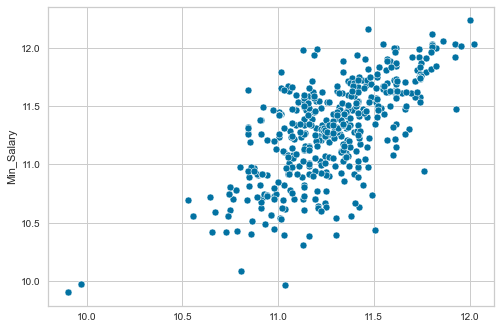

In [89]:
sns.scatterplot(y_preds,y_test_log);

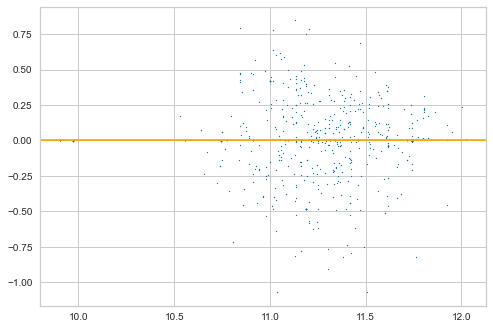

In [90]:
resids = y_test_log - y_preds
plt.scatter(y_preds, resids, s=1)
plt.axhline(0, color="orange");

In [91]:
# data
# 

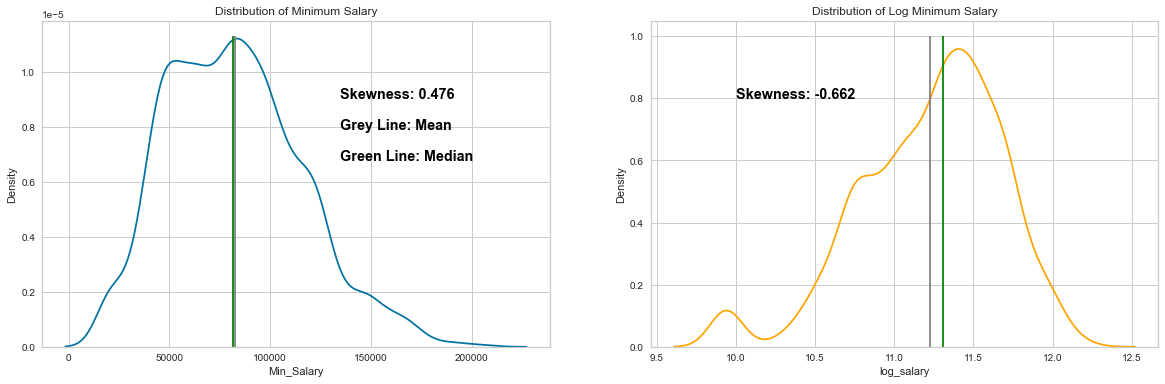

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))
ax1 = sns.kdeplot(ax = axes[0],x = "Min_Salary", data = data)
ax1.vlines(data["Min_Salary"].mean(),ymin = 0, ymax = 0.0000113, color = "grey")
ax1.vlines(data["Min_Salary"].median(),ymin = 0, ymax = 0.0000113, color = "green")
plt.text(7.5, 0.8, "Skewness: 0.476", horizontalalignment='left', size='large', color='black', weight='semibold')
plt.text(7.5, 0.7, "Grey Line: Mean", horizontalalignment='left', size='large', color='black', weight='semibold')
plt.text(7.5, 0.6, "Green Line: Median", horizontalalignment='left', size='large', color='black', weight='semibold')
ax1.title.set_text("Distribution of Minimum Salary")

data['log_salary'] = np.log(data['Min_Salary'])
sns.kdeplot(ax = axes[1],x = "log_salary", data = data, color = "orange")
plt.vlines(data["log_salary"].mean(),ymin = 0, ymax = 1.0, color = "grey")
plt.vlines(data["log_salary"].median(),ymin = 0, ymax = 1.0, color = "green")
plt.text(10, 0.8, "Skewness: -0.662", horizontalalignment='left', size='large', color='black', weight='semibold')
plt.title("Distribution of Log Minimum Salary");

In [93]:
data['Min_Salary'].skew()

0.4761091702190408

In [94]:
data['log_salary'].skew()

-0.6618410836011163

### Neural Net Approach


In [ ]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train_dummies)
X_test_sc = sc.transform(X_test_dummies)

In [ ]:
X_train

In [ ]:
X_train_sc.shape

In [ ]:
# 1. Instantiate Model
model = Sequential()

In [ ]:
# Input layer
model.add(Dense(256, input_shape = (91,)))

# Hidden layer
model.add(Dense(128))
model.add(Dropout(0.05))

# Hidden layer
model.add(Dense(128))
model.add(Dropout(0.05))

# Output layer
model.add(Dense(1,activation=None))

In [ ]:
# 2. Compile
model.compile(loss="mse", optimizer = "adam", metrics = ["r"])

In [ ]:
model.summary()

In [ ]:
# 3. Fit
history = model.fit(X_train_sc, y_train, epochs=100,
                    batch_size = 64,
                    verbose = 0,
                    validation_data= (X_test_sc, y_test)
                   )

In [ ]:
score = model.evaluate(X_test_sc,
                       y_test,
                       verbose=1)

In [ ]:
base_preds = model.predict(X_test_sc).ravel()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Left plot
ax[0].plot(history.history["loss"], label = "Train") # Training Loss (Blue)
ax[0].plot(history.history["val_loss"], label = "Test") # Testing Loss (Orange)
ax[0].legend();

# y = log loss
# x = epochs

# Right plot
ax[1].plot(history.history["accuracy"], label = "Train") # Training accuracy (Blue)
ax[1].plot(history.history["val_accuracy"], label = "Test") # Testing accuracy (Orange)
ax[1].legend();

# y = accuracy
# x = epochs

### Check Job Description Impact

In [ ]:
## Using skills in JD to predict

In [ ]:
# Skills in Job Describtion(JD)
# Python
data['python_jd'] = data['Job_Desc'].apply(lambda x: 1 if 'python' in x.lower() else 0)

# R studio
data['Rstudio_jd'] = data['Job_Desc'].apply(lambda x: 1 if ('R,' in x or 'R-' in x) else 0)

# Excel
data['excel_jd'] = data['Job_Desc'].apply(lambda x: 1 if 'excel' in x.lower() else 0)

# AWS
data['aws_jd'] = data['Job_Desc'].apply(lambda x: 1 if 'aws' in x.lower() else 0)

# Spark
data['spark_jd'] = data['Job_Desc'].apply(lambda x: 1 if 'spark' in x.lower() else 0)

# Big data
data['big_data_jd'] = data['Job_Desc'].apply(lambda x: 1 if 'big data' in x.lower() else 0)

# Key word:
# Data science
data['data_science_jd'] = data['Job_Desc'].apply(lambda x: 1 if 'data science' in x.lower() else 0)

# Data engineering
data['data_engineer_jd'] = data['Job_Desc'].apply(lambda x: 1 if 'data engineer' in x.lower() else 0)

# Data engineering
data['machine_learning_jd'] = data['Job_Desc'].apply(lambda x: 1 if 'machine learning' in x.lower() else 0)

# Education
data['computer_science_jd'] = data['Job_Desc'].apply(lambda x: 1 if 'computer science' in x.lower() else 0)

# Security Clearance
data['security_clearance_jd'] = data['Job_Desc'].apply(lambda x: 1 if 'security clearance' in x.lower() else 0)

In [ ]:
jd_col = data.columns[data.columns.str.contains("jd")].to_list()
jd_col

In [ ]:
data[jd_col].mean()

In [ ]:
# Let's start with Min prediction
X_train, X_test, y_train, y_test = train_test_split(X,ymin,random_state=42)
    
# Split for y_max
X_train, X_test, y_max_train, y_max_test = train_test_split(X,ymax,random_state=42)
    
# Split for y_avg
X_train, X_test, y_avg_train, y_avg_test = train_test_split(X,yavg,random_state=42)

# Dummies
X_train_dummies = pd.get_dummies(X_train, drop_first=True)
X_test_dummies = pd.get_dummies(X_test)

# Reindex
X_test_dummies = X_test_dummies.reindex(X_train_dummies.columns, axis=1)
X_test_dummies.fillna(0, inplace=True)

In [ ]:
# Check correlation with saleprice to find interesting variables.
plt.figure(figsize=(10,12))
sns.heatmap(data.corr()[['Min_Salary']].sort_values(by='Min_Salary', ascending=False),
            annot=True)
plt.title("Top 15 variables with highest correlation with saleprice");

### Most Common Word in Job Description

In [ ]:
data['Job_Desc'] = data['Job_Desc'].replace('\n\n' , " " , regex = True)
data['Job_Desc'] = data['Job_Desc'].replace('\n' , " " , regex = True)

In [ ]:
cvec = CountVectorizer(stop_words="english", min_df = 0.2)
cvec.fit(data["Job_Desc"])

In [ ]:
# Transforming using our fitted cvec and converting the result to a DataFrame
top_words = pd.DataFrame(cvec.transform(data["Job_Desc"]).todense(),
                       columns=cvec.get_feature_names_out())
top_words.shape

In [ ]:
# Finding the top 100 words that frequently appeared in the job description
jd_top = top_words.sum(axis = 0).sort_values(ascending = False).head(100)
jd_top

In [ ]:
cvec = CountVectorizer(stop_words="english", 
                       min_df = 0.05, #
                       ngram_range = (2,2))
docs = cvec.fit_transform(data["Job_Desc"])

In [ ]:
# plt.figure(figsize=(10,12))
# sns.heatmap(cor.corr()[["Min_Salary"]].sort_values(by="Min_Salary", ascending=False),
#             annot=True)
# plt.title("Top 15 variables with highest correlation with Minimum Salary");

In [ ]:
# Transforming using our fitted cvec and converting the result to a DataFrame
top_word_pairs = pd.DataFrame(cvec.transform(data["Job_Desc"]).todense(),
                       columns=cvec.get_feature_names_out())
top_word_pairs.shape

In [ ]:
vec = CountVectorizer(min_df= 2 , stop_words = 'english' , ngram_range = (2,2))
docs = vec.fit_transform(data.Job_Desc)
features = vec.get_feature_names_out()

visualizer = FreqDistVisualizer(features=features, orient='h' , size = (800,800))
visualizer.fit(docs)
visualizer.show();

In [ ]:
X = data["Job_Desc"]
y = data["Min_Salary"]

In [ ]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. LinearRegression (estimator)

pipe = Pipeline([
    ("cvec", CountVectorizer()), # Transformer (fit, transform)
    ("ridge", Ridge()) # Estimator or model (fit, predict)    
])

In [ ]:
pipe_params = {
    "cvec__max_features":[100,250,500],
    "cvec__min_df": [2,3],
    "cvec__max_df": [0.9,0.95],
    "cvec__ngram_range": [(1,1),(2,2)],
    "cvec__stop_words": ["english"]
}

In [ ]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [ ]:
# Fit GridSearch to training data.
start_time = time.time()
gs.fit(X_train,y_train)
print(f"Runtime:{time.time()-start_time}")

In [ ]:
# What's the best score?
gs.best_score_

In [ ]:
# What's the best params?
gs.best_params_

In [ ]:
# Score model on training set.
print(f"Training score:{gs.score(X_train,y_train)}")

# Score model on testing set.
print(f"Training score:{gs.score(X_test,y_test)}")

# Prediction
preds = gs.predict(X_test)
preds = pd.Series(preds, index = X_test.index,
                  name = "Predictions")

pd.concat([y_test, preds], axis=1)

### Only Data Role

In [ ]:
data_only = data[data["is_data"] == True]
data_only.head()

In [ ]:
data_only.shape

In [ ]:
ProfileReport(
    data_only,
    title="Profile Report for variables"   
)

In [ ]:
# X & y
is_col = data_only.columns[data_only.columns.str.contains("is")].to_list()
features = ["Company","State","City","Industry","Job_Type", "Rating"] + is_col
#features = ["State","Industry","Rating","Job_Type"]

X = data_only[features]
ymin = data_only["Min_Salary"]
ymax = data_only["Max_Salary"]
yavg = (data_only["Min_Salary"]+data_only["Max_Salary"])/2

features

X

# Drop Industry_Not enough data, Company Not enough data, City Not enough data

X_dummies = pd.get_dummies(X, columns = ["Company","State",
                                         "City", "Industry", "Job_Type"])
X_dummies.head()

# Let's start with Min prediction
X_train_dummies, X_test_dummies, y_train, y_test = train_test_split(X_dummies,ymin,random_state=42)
    
# Split for y_max
X_train_dummies, X_test_dummies, y_max_train, y_max_test = train_test_split(X_dummies,ymax,random_state=42)
    
# Split for y_avg
X_train_dummies, X_test_dummies, y_avg_train, y_avg_test = train_test_split(X_dummies,yavg,random_state=42)


X_train_dummies.shape, y_train.shape, X_test_dummies.shape, y_test.shape

# Drop Industry_Not enough data, Industry_Unknown
# Company Not enough data, City Not enough data
X_train_dummies.drop(columns = ["Industry_Unknown", "Industry_Not enough data",
                                "Company_Not enough data","City_Not enough data",
                                "Job_Type_PART_TIME", "is_data"],
                     inplace= True)


#X_test = X_test.reindex(columns = X_train.columns, fill_value=0)

# Reindex
X_test_dummies = X_test_dummies.reindex(X_train_dummies.columns, axis=1)
X_test_dummies.fillna(0, inplace=True)

In [ ]:
lazy = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = lazy.fit(X_train_dummies, X_test_dummies, y_train, y_test)

print(models)

In [ ]:
linear = LinearRegression()
linear.fit(X_train_dummies, y_train)

cal_metrics(linear, X_train_dummies, X_test_dummies)

ridge = RidgeCV()

# define model
ridge = RidgeCV(cv = 5)
ridge.fit(X_train_dummies,y_train)

cal_metrics(ridge, X_train_dummies, X_test_dummies)

# define model
lasso = LassoCV(cv = 5)
lasso.fit(X_train_dummies,y_train)

cal_metrics(lasso, X_train_dummies, X_test_dummies)